In [ ]:
import numpy as np
import h5py
import matplotlib.pyplot as plt
import xml.etree.ElementTree as ET

In [ ]:
from time import time
from sklearn import metrics
from sklearn.cluster import KMeans
from sklearn.datasets import load_digits
from sklearn.decomposition import PCA
from sklearn.preprocessing import scale

## User input

In [ ]:
sample_prefix = 'E:\\Ashlee\\PacBio\\181207\\30s_43N43\\m181207_211324_42131_c000468682559900001500000112312060_s1_p0'

## Load data

In [3]:
trc_filename = sample_prefix + '.trc.h5'
mcd_filename = sample_prefix + '.mcd.h5'
upd_filename = sample_prefix + '.upd.h5'
meta_filename = sample_prefix + '.metadata.xml'

trc_file = h5py.File(trc_filename, 'r')
mcd_file = h5py.File(mcd_filename, 'r')
upd_file = h5py.File(upd_filename, 'r')

# Load data in trace file
dset = trc_file['TraceData']
raw_traces = dset['Traces']
decode = dset['Codec']['Decode']
n_traces = raw_traces.shape[0]
n_frames = raw_traces.shape[2]
decode_array = np.array(decode)

# Load data in upd file
upd_TD = upd_file['TraceData']
hole_xy_plot = upd_TD['HoleXYPlot'] # (x,y) coordinates for each well
hole_status = upd_TD['HoleStatus'] # fiducials

# Extract frame rate from metadata
meta_tree = ET.parse(meta_filename)
root = meta_tree.getroot()
for keyval in root.iter('{http://pacificbiosciences.com/PAP/Metadata.xsd}KeyValue'):
    if keyval.attrib['key'] == 'MovieFPS':
        fps = int(keyval.text)
        frame_rate = 1.0/fps # seconds
        break

# For plotting
time_axis = np.arange(n_frames)*frame_rate
colors = ['green', (0, 1, 0), 'red', 'orange']
lasers = ['Cy3', 'Cy3.5', 'Cy5', 'Cy5.5']

## View data structure
def printname(name):
    print(name)

print('In mcd file: ')
mcd_file.visit(printname)
print()

print('In upd file: ')
upd_file.visit(printname)

In [ ]:
# psf = mcd_file['MovieCal']['Camera[0]']['Psf']
# for i in range(1, 3):
#     fig, ax = plt.subplots()
#     im = ax.imshow(psf[0, i, :, :])

## Decode trace intensities

In [ ]:
# traces = np.zeros(raw_traces.shape)
# for i in range(n_traces):
#     traces[i] = decode_array[raw_traces[i]]

In [ ]:
# traces2 = np.zeros(raw_traces.shape, dtype=np.float16)
# for i in range(n_traces):
#     traces2[i] = decode_array[raw_traces[i]]

In [4]:
# Skip decode
traces = raw_traces

## Plot intensity distributions

In [24]:
avg_intens = np.mean(traces, axis=2)

In [ ]:
for i in range(4):
    avg_intens_i = avg_intens.T[i]
    min_i = min(avg_intens_i)
    max_i = max(avg_intens_i)
    plt.hist(avg_intens_i, bins=100, range=[min_i, max_i], histtype='step', color=colors[i])
    
    
plt.xlabel('Intensity')
plt.ylabel('Count')
plt.legend(lasers)

In [ ]:
# for i in range(4):
#     plt.figure()
#     plt.scatter(hole_xy_plot[:, 0], hole_xy_plot[:, 1], hole_status)
#     plt.scatter(hole_xy_plot[:, 0], hole_xy_plot[:, 1], 1, avg_intens.T[i]/300)
#     plt.title(lasers[i] + ' intensity')
#     plt.show()

plt.figure(figsize=(14, 11))
for i in range(4):
    plt.subplot(2, 2, i+1)
    plt.scatter(hole_xy_plot[:, 0], hole_xy_plot[:, 1], hole_status)
    plt.scatter(hole_xy_plot[:, 0], hole_xy_plot[:, 1], 1, avg_intens.T[i])
    plt.title(lasers[i] + ' intensity')
    plt.colorbar()

plt.savefig(sample_prefix + '_grid.png')
plt.show()

## Plot variance distributions

In [11]:
var = np.log10(np.var(traces, axis=2) + 1e-6)

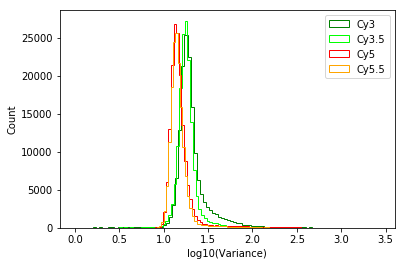

In [12]:
for i in range(4):
    var_i = var.T[i]
    min_i = 0
    max_i = max(var_i)
    plt.hist(var_i, bins=100, range=[min_i, max_i], histtype='step', color=colors[i])
    
plt.xlabel('log10(Variance)')
plt.ylabel('Count')
plt.legend(lasers)

In [ ]:
# Plot variance over the grid

# for i in range(4):
#     plt.figure()
#     plt.scatter(hole_xy_plot[:, 0], hole_xy_plot[:, 1], hole_status)
#     plt.scatter(hole_xy_plot[:, 0], hole_xy_plot[:, 1], 1, var.T[i])
#     plt.title('log10(Variance) of ' + lasers[i])
#     plt.show()

## View a trace

In [ ]:
# i = 112542 # is a good example
i = 4
# i = np.random.randint(0, n_traces)
trace = traces[i]
for j in range(4):
    plt.plot(time_axis, trace[j], color=colors[j])
    j += 1 

plt.xlabel('Time (s)')
plt.ylabel('Intensity')
plt.legend(lasers, bbox_to_anchor=(0.75, 0.5, 0.5, 0.5))

In [ ]:
plt.imshow(traces[:200, 2, :])
plt.colorbar()

In [ ]:
plt.figure(figsize=(10, 4))
plt.imshow(traces[(112542-50):(112542+50), 2, :])
plt.colorbar()
plt.title("Cy5 traces stacked")
plt.xlabel("Frame")
plt.ylabel('Wells')
plt.savefig(sample_prefix + '_cy5_stacked_example.png', dpi=300)

## Plot average intensity over time for each color

In [ ]:
avg_trace = np.zeros((4, n_frames))
for i in range(4):
    avg_trace[i] = np.mean(traces[:][:][i], axis=0)

In [ ]:
for i in range(4):
    plt.plot(time_axis, avg_trace[i], color=colors[i])

plt.xlabel('Time (s)')
plt.ylabel('Intensity')
plt.legend(lasers, bbox_to_anchor=(0.75, 0.5, 0.5, 0.5))

## Sort by correlation

In [25]:
# zero-center the traces
centered_traces = np.zeros(raw_traces.shape)
for i in range(n_traces):
    for j in range(4):
        centered_traces[i, j] = traces[i, j] - avg_intens[i, j]

In [ ]:
i = np.random.randint(0, n_traces)
i = 0
ct = centered_traces[i]
for j in range(4):
    plt.plot(time_axis, ct[j], color=colors[j])
    j += 1 

plt.xlabel('Time (s)')
plt.ylabel('Intensity')
plt.legend(lasers, bbox_to_anchor=(0.75, 0.5, 0.5, 0.5))

In [26]:
# Compute cross-correlation
corr_list = np.zeros(n_traces)
for i in range(n_traces):
    cy3 = centered_traces[i][0]
    cy5 = centered_traces[i][2]
    corr_list[i] = np.correlate(cy3, cy5)

sorting_index = np.argsort(corr_list)

In [ ]:
plt.figure(figsize=(15, 20))
for i in range(10):
    plt.subplot(5, 2, i+1)
    st = traces[sorting_index[i]]
    for j in range(4):
        plt.plot(time_axis, st[j], color=colors[j])
        j += 1 

    plt.xlabel('Time (s)')
    plt.ylabel('Intensity')
    plt.legend(lasers, bbox_to_anchor=(0.75, 0.5, 0.5, 0.5))
    i = i + 1

In [ ]:
scaled_traces = scale(traces[:, [0, 2], :].reshape((n_traces, 2*n_frames)))

In [ ]:
scaled_traces = centered_traces[:, [0, 2], :].reshape((n_traces, 2*n_frames))

In [ ]:
data = scaled_traces
n_samples = n_traces
n_features = 2*n_frames
n_clusters = 2

# def bench_k_means(estimator, name, data):
#     t0 = time()
#     estimator.fit(data)
#     print('%-9s\t%.2fs\t%i\t%.3f\t%.3f\t%.3f\t%.3f\t%.3f\t%.3f'
#           % (name, (time() - t0), estimator.inertia_,
#              metrics.homogeneity_score(labels, estimator.labels_),
#              metrics.completeness_score(labels, estimator.labels_),
#              metrics.v_measure_score(labels, estimator.labels_),
#              metrics.adjusted_rand_score(labels, estimator.labels_),
#              metrics.adjusted_mutual_info_score(labels,  estimator.labels_),
#              metrics.silhouette_score(data, estimator.labels_,
#                                       metric='euclidean',
#                                       sample_size=sample_size)))

# bench_k_means(KMeans(init='k-means++', n_clusters=n_clusters, n_init=10),
#               name="k-means++", data=data)

# bench_k_means(KMeans(init='random', n_clusters=n_digits, n_init=10),
#               name="random", data=data)

# in this case the seeding of the centers is deterministic, hence we run the
# kmeans algorithm only once with n_init=1
pca = PCA(n_components=n_clusters).fit(data)
# bench_k_means(KMeans(init=pca.components_, n_clusters=n_digits, n_init=1),
#               name="PCA-based",
#               data=data)
# print(82 * '_')

# #############################################################################
# Visualize the results on PCA-reduced data

reduced_data = PCA(n_components=2).fit_transform(data)
kmeans = KMeans(init='k-means++', n_clusters=n_clusters, n_init=10)
kmeans.fit(reduced_data)

# Step size of the mesh. Decrease to increase the quality of the VQ.
h = .02     # point in the mesh [x_min, x_max]x[y_min, y_max].

# Plot the decision boundary. For that, we will assign a color to each
x_min, x_max = reduced_data[:, 0].min() - 1, reduced_data[:, 0].max() + 1
y_min, y_max = reduced_data[:, 1].min() - 1, reduced_data[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

# Obtain labels for each point in mesh. Use last trained model.
Z = kmeans.predict(np.c_[xx.ravel(), yy.ravel()])

# Put the result into a color plot
Z = Z.reshape(xx.shape)
plt.figure(1)
plt.clf()
plt.imshow(Z, interpolation='nearest',
           extent=(xx.min(), xx.max(), yy.min(), yy.max()),
           cmap=plt.cm.Paired,
           aspect='auto', origin='lower')

plt.plot(reduced_data[:, 0], reduced_data[:, 1], 'k.', markersize=2)
# Plot the centroids as a white X
centroids = kmeans.cluster_centers_
plt.scatter(centroids[:, 0], centroids[:, 1],
            marker='x', s=169, linewidths=3,
            color='w', zorder=10)
plt.title('K-means clustering on the 30s dataset (PCA-reduced data)\n'
          'Centroids are marked with white cross')
plt.xlim(x_min, x_max)
plt.ylim(y_min, y_max)
plt.xticks(())
plt.yticks(())
plt.show()

In [ ]:
kmeans = KMeans(init='k-means++', n_clusters=n_clusters, n_init=10)
kmeans.fit(data)

In [ ]:
labels = kmeans.labels_
plt.hist(labels)

In [ ]:
ones = []
zeros = []
for i in range(len(labels)):
    if labels[i] == 0:
        zeros.append(i)
    else:
        ones.append(i)

In [ ]:
plt.figure(figsize=(15, 100))
for i in range(100):
    plt.subplot(50, 2, i+1)
    st = traces[ones[i]]
    for j in range(4):
        plt.plot(time_axis, st[j], color=colors[j])
        j += 1 

    plt.xlabel('Time (s)')
    plt.ylabel('Intensity')
    plt.legend(lasers, bbox_to_anchor=(0.75, 0.5, 0.5, 0.5))
    i = i + 1

In [ ]:
plt.figure(figsize=(15, 100))
for i in range(100):
    plt.subplot(50, 2, i+1)
    st = traces[zeros[i]]
    for j in range(4):
        plt.plot(time_axis, st[j], color=colors[j])
        j += 1 

    plt.xlabel('Time (s)')
    plt.ylabel('Intensity')
    plt.legend(lasers, bbox_to_anchor=(0.75, 0.5, 0.5, 0.5))
    i = i + 1

In [ ]:
plt.hist(corr_list, bins = 50, range=[-4e5, 4e5])

In [5]:
max_intens = np.zeros((2, n_traces))
min_intens = np.zeros((2, n_traces))
for i in range(n_traces):
    trace = traces[i]
    max_intens[0, i] = np.max(trace[0])
    min_intens[0, i] = np.min(trace[0])
    max_intens[1, i] = np.max(trace[2])
    min_intens[1, i] = np.min(trace[2])

diff = min_intens - max_intens

diff_sort_cy5 = np.argsort(diff[1])

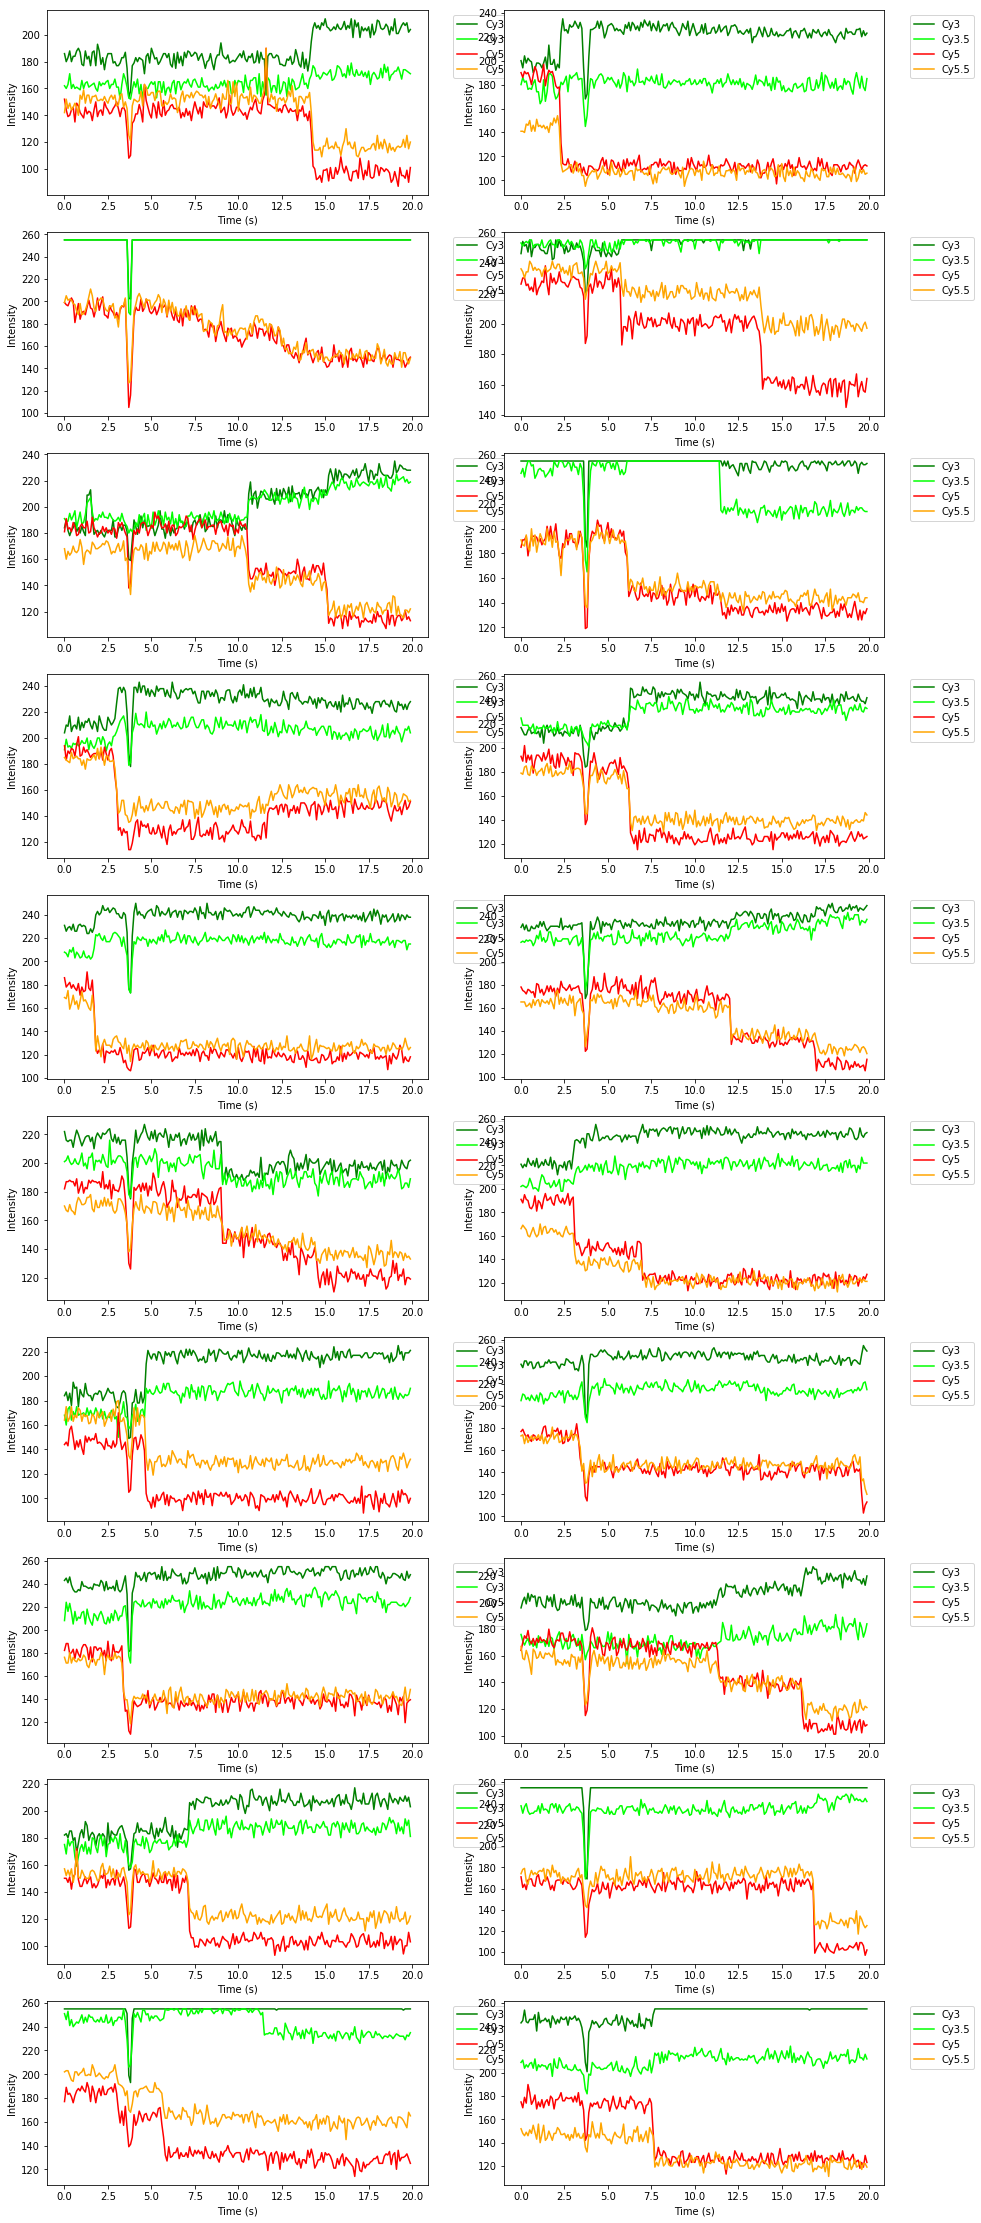

In [6]:
plt.figure(figsize=(15, 40))
for i in range(20):
    plt.subplot(10, 2, i+1)
    st = traces[diff_sort_cy5[i]]
    for j in range(4):
        plt.plot(time_axis, st[j], color=colors[j])
        j += 1 

    plt.xlabel('Time (s)')
    plt.ylabel('Intensity')
    plt.legend(lasers, bbox_to_anchor=(0.75, 0.5, 0.5, 0.5))
    i = i + 1

(array([1.0000e+00, 2.0000e+00, 0.0000e+00, 1.0000e+00, 0.0000e+00,
        2.0000e+00, 4.0000e+00, 2.0000e+00, 4.0000e+00, 3.0000e+00,
        2.2000e+01, 1.6000e+01, 4.3000e+01, 7.1000e+01, 4.4000e+01,
        1.0700e+02, 1.0600e+02, 1.9200e+02, 1.7000e+02, 3.0000e+02,
        3.9000e+02, 3.1200e+02, 5.6000e+02, 4.5100e+02, 8.8300e+02,
        6.9500e+02, 1.2920e+03, 1.8400e+03, 2.1100e+03, 8.0050e+03,
        1.5488e+04, 5.5409e+04, 4.6063e+04, 2.5060e+04, 8.7600e+02,
        1.1200e+02, 1.9000e+02, 1.1200e+02, 1.5300e+02, 2.3910e+03]),
 array([-103.   , -100.425,  -97.85 ,  -95.275,  -92.7  ,  -90.125,
         -87.55 ,  -84.975,  -82.4  ,  -79.825,  -77.25 ,  -74.675,
         -72.1  ,  -69.525,  -66.95 ,  -64.375,  -61.8  ,  -59.225,
         -56.65 ,  -54.075,  -51.5  ,  -48.925,  -46.35 ,  -43.775,
         -41.2  ,  -38.625,  -36.05 ,  -33.475,  -30.9  ,  -28.325,
         -25.75 ,  -23.175,  -20.6  ,  -18.025,  -15.45 ,  -12.875,
         -10.3  ,   -7.725,   -5.15 ,   -2.575

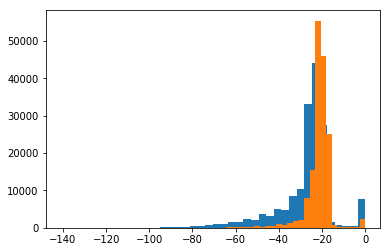

In [10]:
plt.hist(diff[0], bins=40)
plt.hist(diff[1], bins=40)

In [14]:
var.shape

(163482, 4)

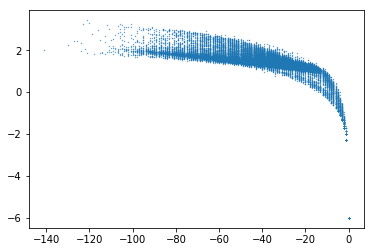

In [18]:
plt.scatter(diff[0], var[:, 0], s=0.1)

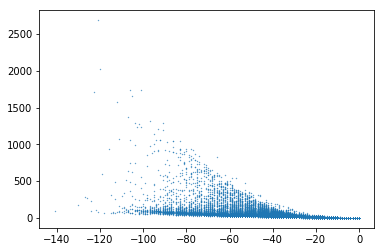

In [22]:
var2 = np.var(traces, axis=2)
plt.scatter(diff[0], var2[:, 0], s=0.1)

In [ ]:
diff_sort_cy5 = np.argsort(diff[1])

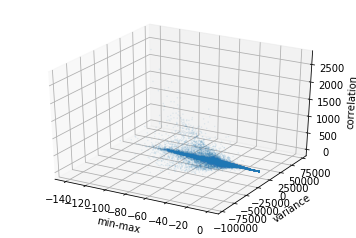

In [32]:
from mpl_toolkits.mplot3d import Axes3D  # noqa: F401 unused import

import matplotlib.pyplot as plt
import numpy as np

# Fixing random state for reproducibility
# np.random.seed(19680801)


# def randrange(n, vmin, vmax):
#     '''
#     Helper function to make an array of random numbers having shape (n, )
#     with each number distributed Uniform(vmin, vmax).
#     '''
#     return (vmax - vmin)*np.random.rand(n) + vmin

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# n = 100

# For each set of style and range settings, plot n random points in the box
# defined by x in [23, 32], y in [0, 100], z in [zlow, zhigh].
# for c, m, zlow, zhigh in [('r', 'o', -50, -25), ('b', '^', -30, -5)]:
xs = diff[0]
ys = var2[:, 0]
zs = corr_list
ax.scatter(xs, zs, ys, alpha=0.1, s=0.2)

ax.set_xlabel('min-max')
ax.set_ylabel('variance')
ax.set_zlabel('correlation')

plt.show()

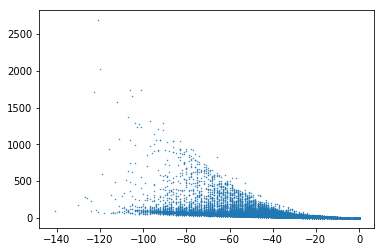

In [34]:
plt.scatter(xs, ys, s=0.2)

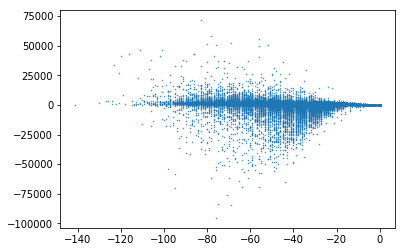

In [35]:
plt.scatter(xs, zs, s=0.2)

(-100, 3000)

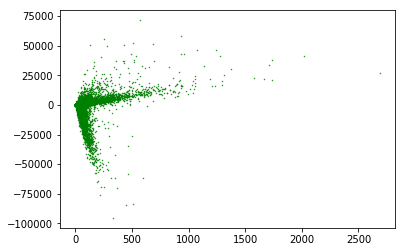

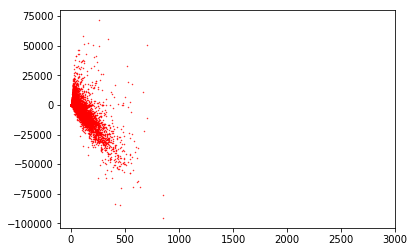

In [42]:
plt.scatter(ys, zs, s=0.2, c="green")
plt.figure()
plt.scatter(var2[:, 2], zs, s=0.2, c="red")
plt.xlim([-100, 3000])